# Using code from John to generate some data for test

In [27]:
# functions from John Slattery's work

import numpy as np


def linear_ramp(t, t0=0.0, dt=1.0, y0=0.0, dy=1.0, GS_slope = 0.0, GIS_slope=0.0):
    """Linear Ramp Function

    This function describes the piece-wise linear ramp.

    Parameter
    ---------
    t : np.ndarray
        Time variable
    t0 : float
        Start time of the ramp
    dt : float
        Transition length
    y0 : float
        Function value before the transition
    dy : float
        Hight of the transition
    GS_slope : float
        slope before transition - can be positive or negative
    GIS_slope : float
        slope after transition - can be positive or negative

    Return
    ------
    y : np.ndarray
        Function values of the linear transiton
    """
    lt_t0 = t < t0
    gt_t1 = t > t0 + dt
    condlist = [lt_t0,
                ~np.logical_or(lt_t0, gt_t1),
                gt_t1]
    funclist = [lambda t: y0 + GS_slope * (t - t0),
                lambda t: y0 + dy * (t - t0) / dt,
                lambda t: y0 + dy + GIS_slope * (t - t0 - dt)]
    y = np.piecewise(t, condlist, funclist)
    return y


def sample_ar1(n, alpha, sigma=1.0, x0=0):
    """Generate AR(1) noise for evenely sampled series"""
    x = np.zeros(n)
    x[0] = x0 + sigma * np.random.randn()
    sigma_e = np.sqrt(sigma ** 2 * (1 - alpha ** 2))
    for i in range(1, n):
        x[i] = alpha * x[i - 1] + sigma_e * np.random.randn()
    return x


import numpy as np

def cal_snr(signal, noise):
    """
    Calculate Signal-to-Noise Ratio (SNR) given signal and noise.

    Args:
    signal (numpy.ndarray): Signal data.
    noise (numpy.ndarray): Noise data.

    Returns:
    float: Signal-to-Noise Ratio (SNR) in decibels (dB).
    """
    signal_power = np.mean(np.square(signal))  # Calculate signal power
    noise_power = np.mean(np.square(noise))    # Calculate noise power

    # snr = 10 * (np.log10(signal_power) - np.log10(noise_power))  # Calculate SNR in dB
    snr = noise_power/signal_power  # Calculate SNR 
    return snr



import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

def gen_dummy_DO(length, delta=10.0, t0=800.0, dt=50.0, dy=1.0, GS_slope=5e-4, GIS_slope=-1e-3, tau=1.0, sigma=0.05):
    """
    Generate dummy time series data for demonstration purposes.

    Args:
    length (int): Length of the time series data.
    delta (float): Time step.
    t0 (float): Starting time.
    dt (float): Duration of the transition.
    dy (float): Amplitude of the transition.
    GS_slope (float): Slope of the Gaussian-shaped transition.
    GIS_slope (float): Slope of the Glacial-interglacial-shaped transition.
    causal_strength (float): Strength of the causal link.
    sigma (float): Standard deviation of the noise.
    tau (float): Time constant for the autoregressive process.

    Returns:
    pandas.DataFrame: DataFrame containing dummy time series data.
    """
    alpha = np.exp(-delta / tau)
    # time = np.arange(t0, t0 + length * delta, step=delta, dtype='float')
    time = np.arange(length, step=delta, dtype='float')
    trans = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=dy, GS_slope=GS_slope, GIS_slope=GIS_slope)
    noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
    synt_trans = trans + noise

    df = pd.DataFrame({
        'time': time,
        'A': synt_trans
    })

    return df

def gen_linked_data(df, lag=10, causal_strength=0.5, delta=10.0, tau=1.0, sigma=0.05):
    """
    Generate causally linked synthetic data.

    Args:
    df (pandas.DataFrame): DataFrame containing synthetic time series data.
    lag (int): Lag for the causal effect. Positive lag means left shifting the series.
    causal_strength (float): Strength of the causal link.
    delta (float): Time step.
    tau (float): Time constant for the autoregressive process.
    sigma (float): Standard deviation of the noise.


    Returns:
    pandas.DataFrame: DataFrame containing causally linked synthetic data.
    """
    synt_trans = df['A'].values
    alpha = np.exp(-delta / tau)
    # Shift the series
    if lag > 0:
        left_shifted_synt_trans = np.full_like(synt_trans, np.nan)
        left_shifted_synt_trans[:-lag] = synt_trans[lag:]
    if lag < 0:
        left_shifted_synt_trans = np.full_like(synt_trans, np.nan)
        left_shifted_synt_trans[-lag:] = synt_trans[:lag]
    if lag == 0:
        left_shifted_synt_trans=synt_trans

    # Generate AR(1) noise as the base for the second causally linked dataset
    new_noise = sample_ar1(len(synt_trans), alpha=alpha, sigma=sigma, x0=0)

    # Combine the lagged original series with the new AR(1) series to produce the causally linked series
    causally_linked_synt_trans = new_noise + causal_strength * left_shifted_synt_trans

    df['B'] = causally_linked_synt_trans
    return df.dropna()








Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    45.656               0.000                5                True
B => A    3.065               0.012                5                True



d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


True

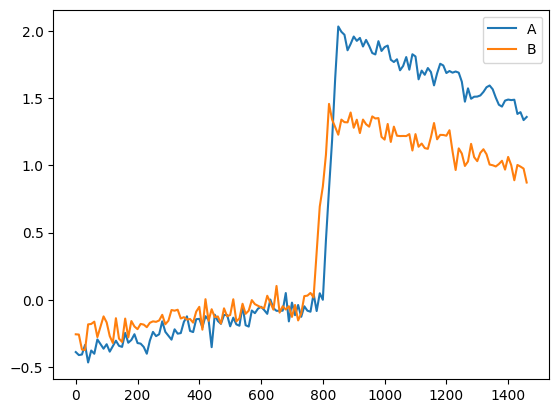

In [95]:
# Example usage:
# Generate dummy data
dummy_warming = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=50.0, dy=2.0, GS_slope=5e-4, GIS_slope=-1e-3, sigma=0.05, tau=1.0)

# Generate causally linked data with lag=5
dummy_warming_lagged = gen_linked_data(dummy_warming, causal_strength=0.7, delta=10.0, lag=3, tau=1.0, sigma=0.05)
dummy_warming_lagged


# plot the dummy_warming_lagged
import matplotlib.pyplot as plt
plt.plot(dummy_warming_lagged['time'], dummy_warming_lagged['A'], label='A')
plt.plot(dummy_warming_lagged['time'], dummy_warming_lagged['B'], label='B')
# add legend
plt.legend()


# get the last two columns of the dataframe
df_gc=dummy_warming_lagged.iloc[:, -2:]
df_gc

from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module

df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19)
causal_AB = gc_results_A_B[0]['XY']
causal_AB

Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    28.065               0.000                9                True
B => A    1.113               0.356                13                False



C:\Users\User\AppData\Local\Temp\ipykernel_22824\653520582.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_warming_lagged['A'] = dummy_warming['A']
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


True

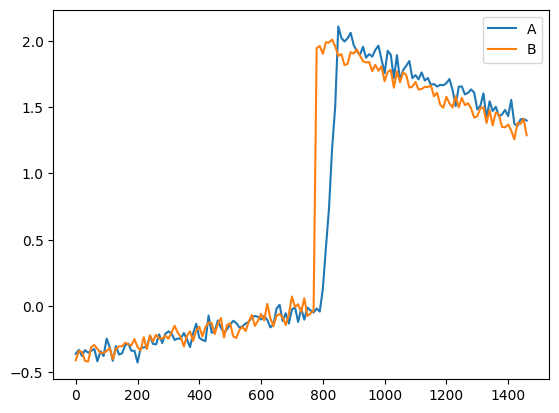

In [131]:
# Example usage:
# Generate dummy data
dummy_warming = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=50.0, dy=2.0, GS_slope=5e-4, GIS_slope=-1e-3, sigma=0.05, tau=1.0)

time = np.arange(1500, step=10, dtype='float')
trans = linear_ramp(time, t0=800, dt=10, y0=0.0, dy=2, GS_slope=5e-4, GIS_slope=-1e-3)

df = pd.DataFrame({
    'time': time,
    'A': trans
})

# Generate causally linked data with lag=5
dummy_warming_lagged = gen_linked_data(df, causal_strength=1, delta=10.0, lag=3, tau=1.0, sigma=0.05)
dummy_warming_lagged

# replace column A with dummy_warming

dummy_warming_lagged['A'] = dummy_warming['A']


# plot the dummy_warming_lagged
import matplotlib.pyplot as plt
plt.plot(dummy_warming_lagged['time'], dummy_warming_lagged['A'], label='A')
plt.plot(dummy_warming_lagged['time'], dummy_warming_lagged['B'], label='B')
# add legend
plt.legend()


# get the last two columns of the dataframe
df_gc=dummy_warming_lagged.iloc[:, -2:]
df_gc

from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module

df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19)
causal_AB = gc_results_A_B[0]['XY']
causal_AB

# Parameters need to be changing: causal strength, lag, sigma, tau

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

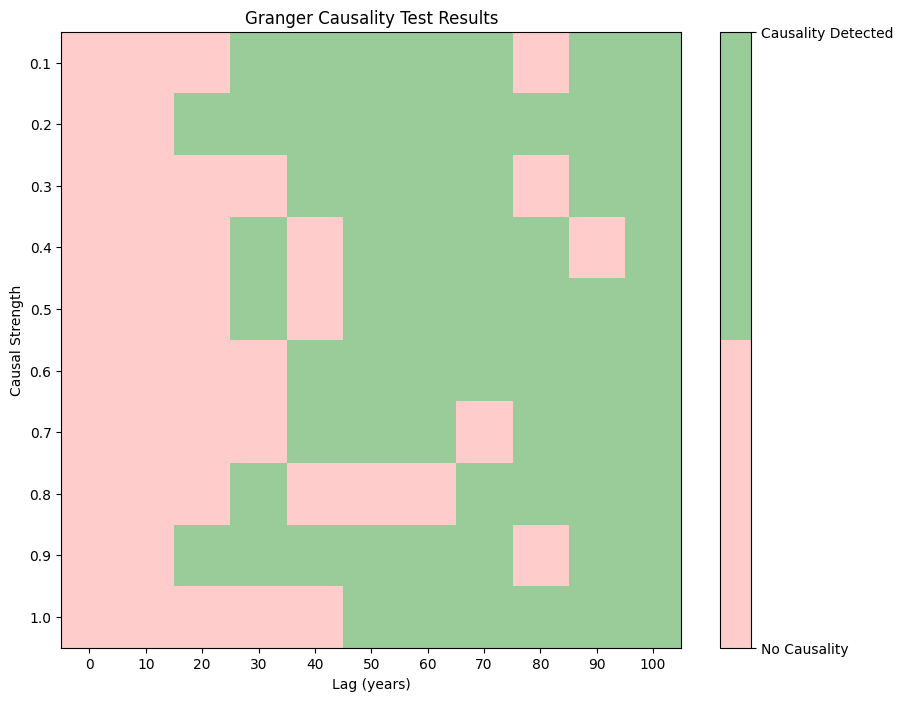

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolbox import GC_functions as GC



# Initialize the results matrix
causal_strengths = np.arange(0.1, 1.1, 0.1) # From 0.1 to 1.0 in steps of 0.1
lags = range(11) # From 0 to 10
results = np.zeros((len(causal_strengths), len(lags)), dtype=bool)


# Loop through the combinations of causal strengths and lags
for i, strength in enumerate(causal_strengths):
    for j, lag in enumerate(lags):
        # Generate the data
        dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=50.0, dy=2.0, GS_slope=5e-4, GIS_slope=-1e-3, sigma=0.05, tau=1.0)
        linked_data = gen_linked_data(dummy_data, causal_strength=strength, delta=10.0, lag=lag, tau=1.0, sigma=0.05)
 
        # Check stationarity and perform Granger Causality test
        df_gc = linked_data[['A', 'B']]
        df_gc_checked = GC.make_stationary(df_gc, ['A', 'B'], test_method='ADF', plot=False)
        gc_results = GC.gc4vars(df_gc_checked, max_lags=19, print_results=False)

        # causal_relation = gc_results[0]['XY']
        # results[i, j] = causal_relation
        

        if gc_results[0]['XY']==True and gc_results[0]['YX']==False:
            causal_relation = gc_results[0]['XY']

            # Store the result
            results[i, j] = causal_relation

# Plotting the heatmap with the modified colorbar
plt.figure(figsize=(10, 8))
# Define a colormap with two colors
cmap = ListedColormap(['#ffcccc', '#99cc99'])  # Red for False, Green for True

plt.imshow(results, cmap=cmap, aspect='auto')
# Create a colorbar with a tick for each color
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['No Causality', 'Causality Detected'])  # Define tick labels
# plt.xticks(range(len(lags)), labels=lags)
# set xtick labels to be xticks*10
plt.xticks(range(len(lags)), labels=[str(i*10) for i in lags])
plt.yticks(range(len(causal_strengths)), labels=np.round(causal_strengths, 1))
plt.xlabel('Lag (years)')
plt.ylabel('Causal Strength')
plt.title('Granger Causality Test Results')
plt.show()


Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    11.568               0.000                8                True
B => A    1.711               0.058                15                False

Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    10.489               0.000                9                True
B => A    2.237               0.068                4                False

Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    15.326               0.000                7                Tr

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    10.989               0.000                12                True
B => A    0.830               0.667                19                False

Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    11.468               0.000                14                True
B => A    1.821               0.031                19                True

Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    9.262               0.000                15                True
B => A    1.575               

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    6.448               0.000                15                True
B => A    1.002               0.466                19                False

Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    13.154               0.000                14                True
B => A    4.387               0.038                1                True

Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    8.365               0.000                18                True
B => A    1.043               0.

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    5.145               0.000                19                True
B => A    1.879               0.157                2                False

Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    4.737               0.000                17                True
B => A    1.288               0.232                13                False

Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    8.180               0.000                18                True
B => A    0.638               0.

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


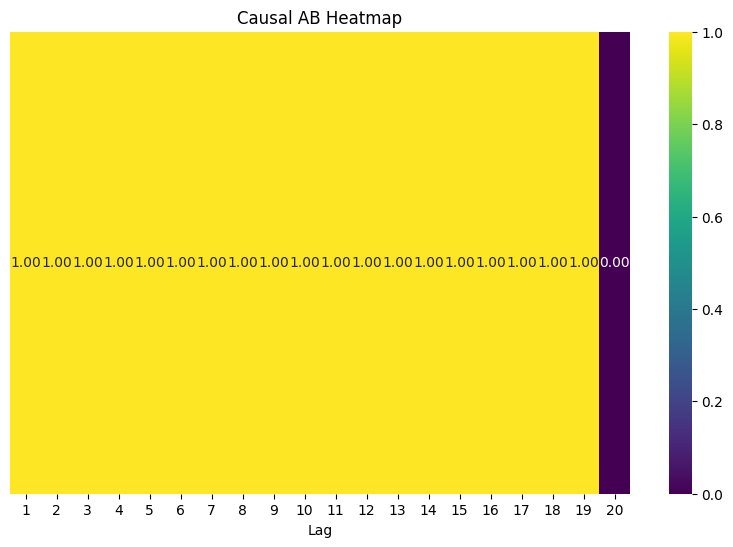

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module

# Constants
delta = 10.0
t0 = 800.0
dt = 50.0
dy = 1.0
GS_slope = 5e-4
GIS_slope = -1e-3
causal_strength = 0.5

sigma = 0.05
tau = 1.0

# Lag range
lags = np.arange(1, 21, 1)

alpha = np.exp(-delta / tau)
time = np.arange(1600, step=delta, dtype='float')
trans = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=dy, GS_slope=GS_slope, GIS_slope=GIS_slope)
noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
synt_trans = trans + noise

# Store causal_AB values for different lags
causal_AB_values = np.zeros((len(lags),))

# Loop through different lags
for i, lag in enumerate(lags):


    left_shifted_synt_trans = np.full_like(synt_trans, np.nan)
    left_shifted_synt_trans[:-lag] = synt_trans[lag:]

    new_noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
    causally_linked_synt_trans = new_noise + causal_strength * left_shifted_synt_trans

    df_gc = pd.DataFrame({
        'A': synt_trans,
        'B': causally_linked_synt_trans
    })

    df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
    gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19)
    causal_AB = gc_results_A_B[0]['XY']
    causal_AB_values[i] = causal_AB

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(causal_AB_values.reshape(1, -1), cmap='viridis', xticklabels=lags, yticklabels=False, annot=True, fmt=".2f")
plt.xlabel('Lag')
plt.ylabel('')
plt.title('Causal AB Heatmap')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module


# Constants
delta = 10.0
t0 = 400.0
dt = 50.0
dy = 1.0
GS_slope = 5e-4
GIS_slope = -1e-3
lag = 10
causal_strength = 0.5

# Parameter ranges
sigmas = np.arange(0.1, 0.21, 0.01)
taus = np.arange(1, 5, 1)

# Store causal_AB values
causal_AB_values = np.zeros((len(sigmas), len(taus)))

# Loop through sigma and tau
for i, sigma in enumerate(sigmas):
    for j, tau in enumerate(taus):
        alpha = np.exp(-delta / tau)
        time = np.arange(800, step=delta, dtype='float')
        trans = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=1.0, GS_slope=GS_slope, GIS_slope=GIS_slope)
        noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
        synt_trans = trans + noise

        left_shifted_synt_trans = np.full_like(synt_trans, np.nan)
        left_shifted_synt_trans[:-lag] = synt_trans[lag:]

        new_noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
        causally_linked_synt_trans = new_noise + causal_strength * left_shifted_synt_trans

        df_gc = pd.DataFrame({
            'A': synt_trans,
            'B': causally_linked_synt_trans
        })

        df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
        gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=20)
        causal_AB = gc_results_A_B[0]['XY']
        causal_AB_values[i, j] = causal_AB

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(causal_AB_values, cmap='viridis', xticklabels=taus, yticklabels=sigmas, annot=True, fmt=".2f")
plt.xlabel('Tau')
plt.ylabel('Sigma')
plt.title('Causal AB Heatmap')
plt.show()


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Parameters for the first synthetic transition
delta = 10.0
t0 = 400.0
dt = 50.0
dy = 1.0
GS_slope = 5e-4
GIS_slope = -1e-3
sigma = 0.1
tau = 1.0
alpha = np.exp(-delta / tau)
time = np.arange(800, step=delta, dtype='float')
trans = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=1.0, GS_slope=GS_slope, GIS_slope=GIS_slope)
noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)

# Add white noise to the transition
# synt_trans = trans + np.random.normal(0, 0.1, len(time))
synt_trans = trans + noise

lag = 10  # 10 years lag for the causal effect
causal_strength = 0.5  # The strength of the causal link

# Shift the series 10 units to the left
left_shifted_synt_trans = np.full_like(synt_trans, np.nan)  # Initialize an array of NaNs
left_shifted_synt_trans[:-lag] = synt_trans[lag:]  # Shift the series to the left

# Generate AR(1) noise as the base for the second causally linked dataset
new_noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
# Combine the lagged original series with the new AR(1) series to produce the causally linked series
causally_linked_synt_trans = new_noise + causal_strength * left_shifted_synt_trans

snr=cal_snr(trans, noise)
# snr

df_gc = pd.DataFrame({
    'A': synt_trans,
    'B': causally_linked_synt_trans
})

import importlib
from toolbox import GC_functions as GC
importlib.reload(GC)

df_gc_checked=GC.make_stationary(df_gc,['A', 'B'], test_method='ADF',plot=False)

gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=20)
# gc_results_A_B


cause_AB=gc_results_A_B[0]['XY']  

ADF Statistic: -0.9852105928579051
p-value: 0.7586201068224167
Critical Values:
	1%: -3.517113604831504
	5%: -2.8993754262546574
	10%: -2.5869547797501644
The series is not stationary.
ADF Statistic: -11.900757525992663
p-value: 5.582552813460876e-22
Critical Values:
	1%: -3.517113604831504
	5%: -2.8993754262546574
	10%: -2.5869547797501644
The series is stationary.
Series in column 'A' is stationary after 1 differencing operation(s).
ADF Statistic: -1.527601732090001
p-value: 0.5198156680575973
Critical Values:
	1%: -3.5319549603840894
	5%: -2.905755128523123
	10%: -2.5903569458676765
The series is not stationary.
ADF Statistic: -11.365526528470474
p-value: 9.247160524381692e-21
Critical Values:
	1%: -3.5319549603840894
	5%: -2.905755128523123
	10%: -2.5903569458676765
The series is stationary.
Series in column 'B' is stationary after 1 differencing operation(s).
Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Dire

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


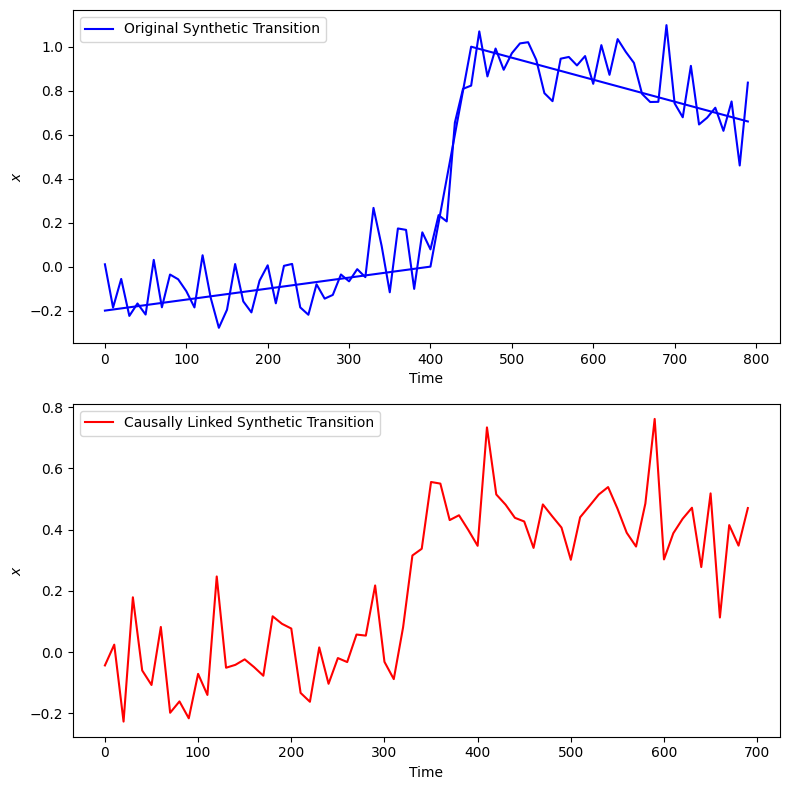

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Parameters for the first synthetic transition
delta = 10.0
t0 = 400.0
dt = 50.0
dy = 1.0
GS_slope = 5e-4
GIS_slope = -1e-3
sigma = 0.1
tau = 1.0
alpha = np.exp(-delta / tau)
time = np.arange(800, step=delta, dtype='float')
trans = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=1.0, GS_slope=GS_slope, GIS_slope=GIS_slope)
noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)

# Add white noise to the transition
# synt_trans = trans + np.random.normal(0, 0.1, len(time))
synt_trans = trans + noise

lag = 10  # 10 years lag for the causal effect
causal_strength = 0.5  # The strength of the causal link

left_shifted_trans = np.full_like(trans, np.nan)  # Initialize an array of NaNs
left_shifted_trans[:-lag] = trans[lag:]  # Shift the series to the left
left_shifted_trans=left_shifted_trans*causal_strength

# Generate a second dataset that is causally linked to the first
# Introduce a lag for the causal effect

# lagged_synt_trans = np.roll(synt_trans, lag)
# # Introduce a lag for the causal effect without wrapping
# lagged_synt_trans = np.full_like(synt_trans, np.nan)  # Initialize an array of NaNs
# lagged_synt_trans[lag:] = synt_trans[:-lag]  # Shift the series without wrapping

# Shift the series 10 units to the left
left_shifted_synt_trans = np.full_like(synt_trans, np.nan)  # Initialize an array of NaNs
left_shifted_synt_trans[:-lag] = synt_trans[lag:]  # Shift the series to the left



# Generate AR(1) noise as the base for the second causally linked dataset
new_noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
# Combine the lagged original series with the new AR(1) series to produce the causally linked series
causally_linked_synt_trans = new_noise + causal_strength * left_shifted_synt_trans
# causally_linked_synt_trans =  causal_strength * lagged_synt_trans

df_gc = pd.DataFrame({
    'A': synt_trans,
    'B': causally_linked_synt_trans
})

# Plot the original and the causally linked datasets
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot the original synthetic transition
axs[0].plot(time, trans, 'b')
axs[0].plot(time, synt_trans, color='b', label='Original Synthetic Transition')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('$x$')
axs[0].legend()

# Plot the causally linked synthetic transition
axs[1].plot(time, causally_linked_synt_trans, color='r', label='Causally Linked Synthetic Transition')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$x$')
axs[1].legend()

plt.tight_layout()
plt.show()


In [25]:
snr=cal_snr(trans, noise)
snr

0.040751393189024765

In [20]:
! pip install networkx

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   --- ------------------------------------ 0.2/2.1 MB 5.0 MB/s eta 0:00:01
   --------- ------------------------------ 0.5/2.1 MB 6.4 MB/s eta 0:00:01
   ---------------- ----------------------- 0.8/2.1 MB 6.6 MB/s eta 0:00:01
   ------------------------ --------------- 1.3/2.1 MB 8.0 MB/s eta 0:00:01
   -------------------------------- ------- 1.7/2.1 MB 7.8 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 7.8 MB/s eta 0:00:00


# Check stationarity

ADF Statistic: -2.152782326080346
p-value: 0.223826604376337
Critical Values:
	1%: -3.520713130074074
	5%: -2.9009249540740742
	10%: -2.5877813777777776
The series is not stationary.


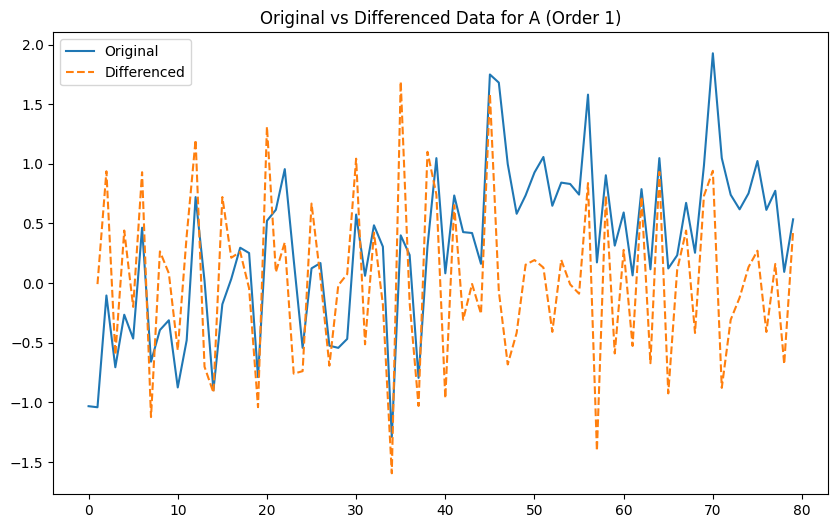

ADF Statistic: -6.713610614791598
p-value: 3.6283451534287446e-09
Critical Values:
	1%: -3.5219803175527606
	5%: -2.9014701097664504
	10%: -2.58807215485756
The series is stationary.
Series in column 'A' is stationary after 1 differencing operation(s).
ADF Statistic: -7.428623875203803
p-value: 6.448596563111782e-11
Critical Values:
	1%: -3.528889992207215
	5%: -2.9044395987933362
	10%: -2.589655654274312
The series is stationary.
Series in column 'B' is stationary after 0 differencing operation(s).
Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    4.308               0.001                15                True
B => A    1.675               0.120                12                False

[{'variables': ('A', 'B'), 'XY': True, 'YX': False}]


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


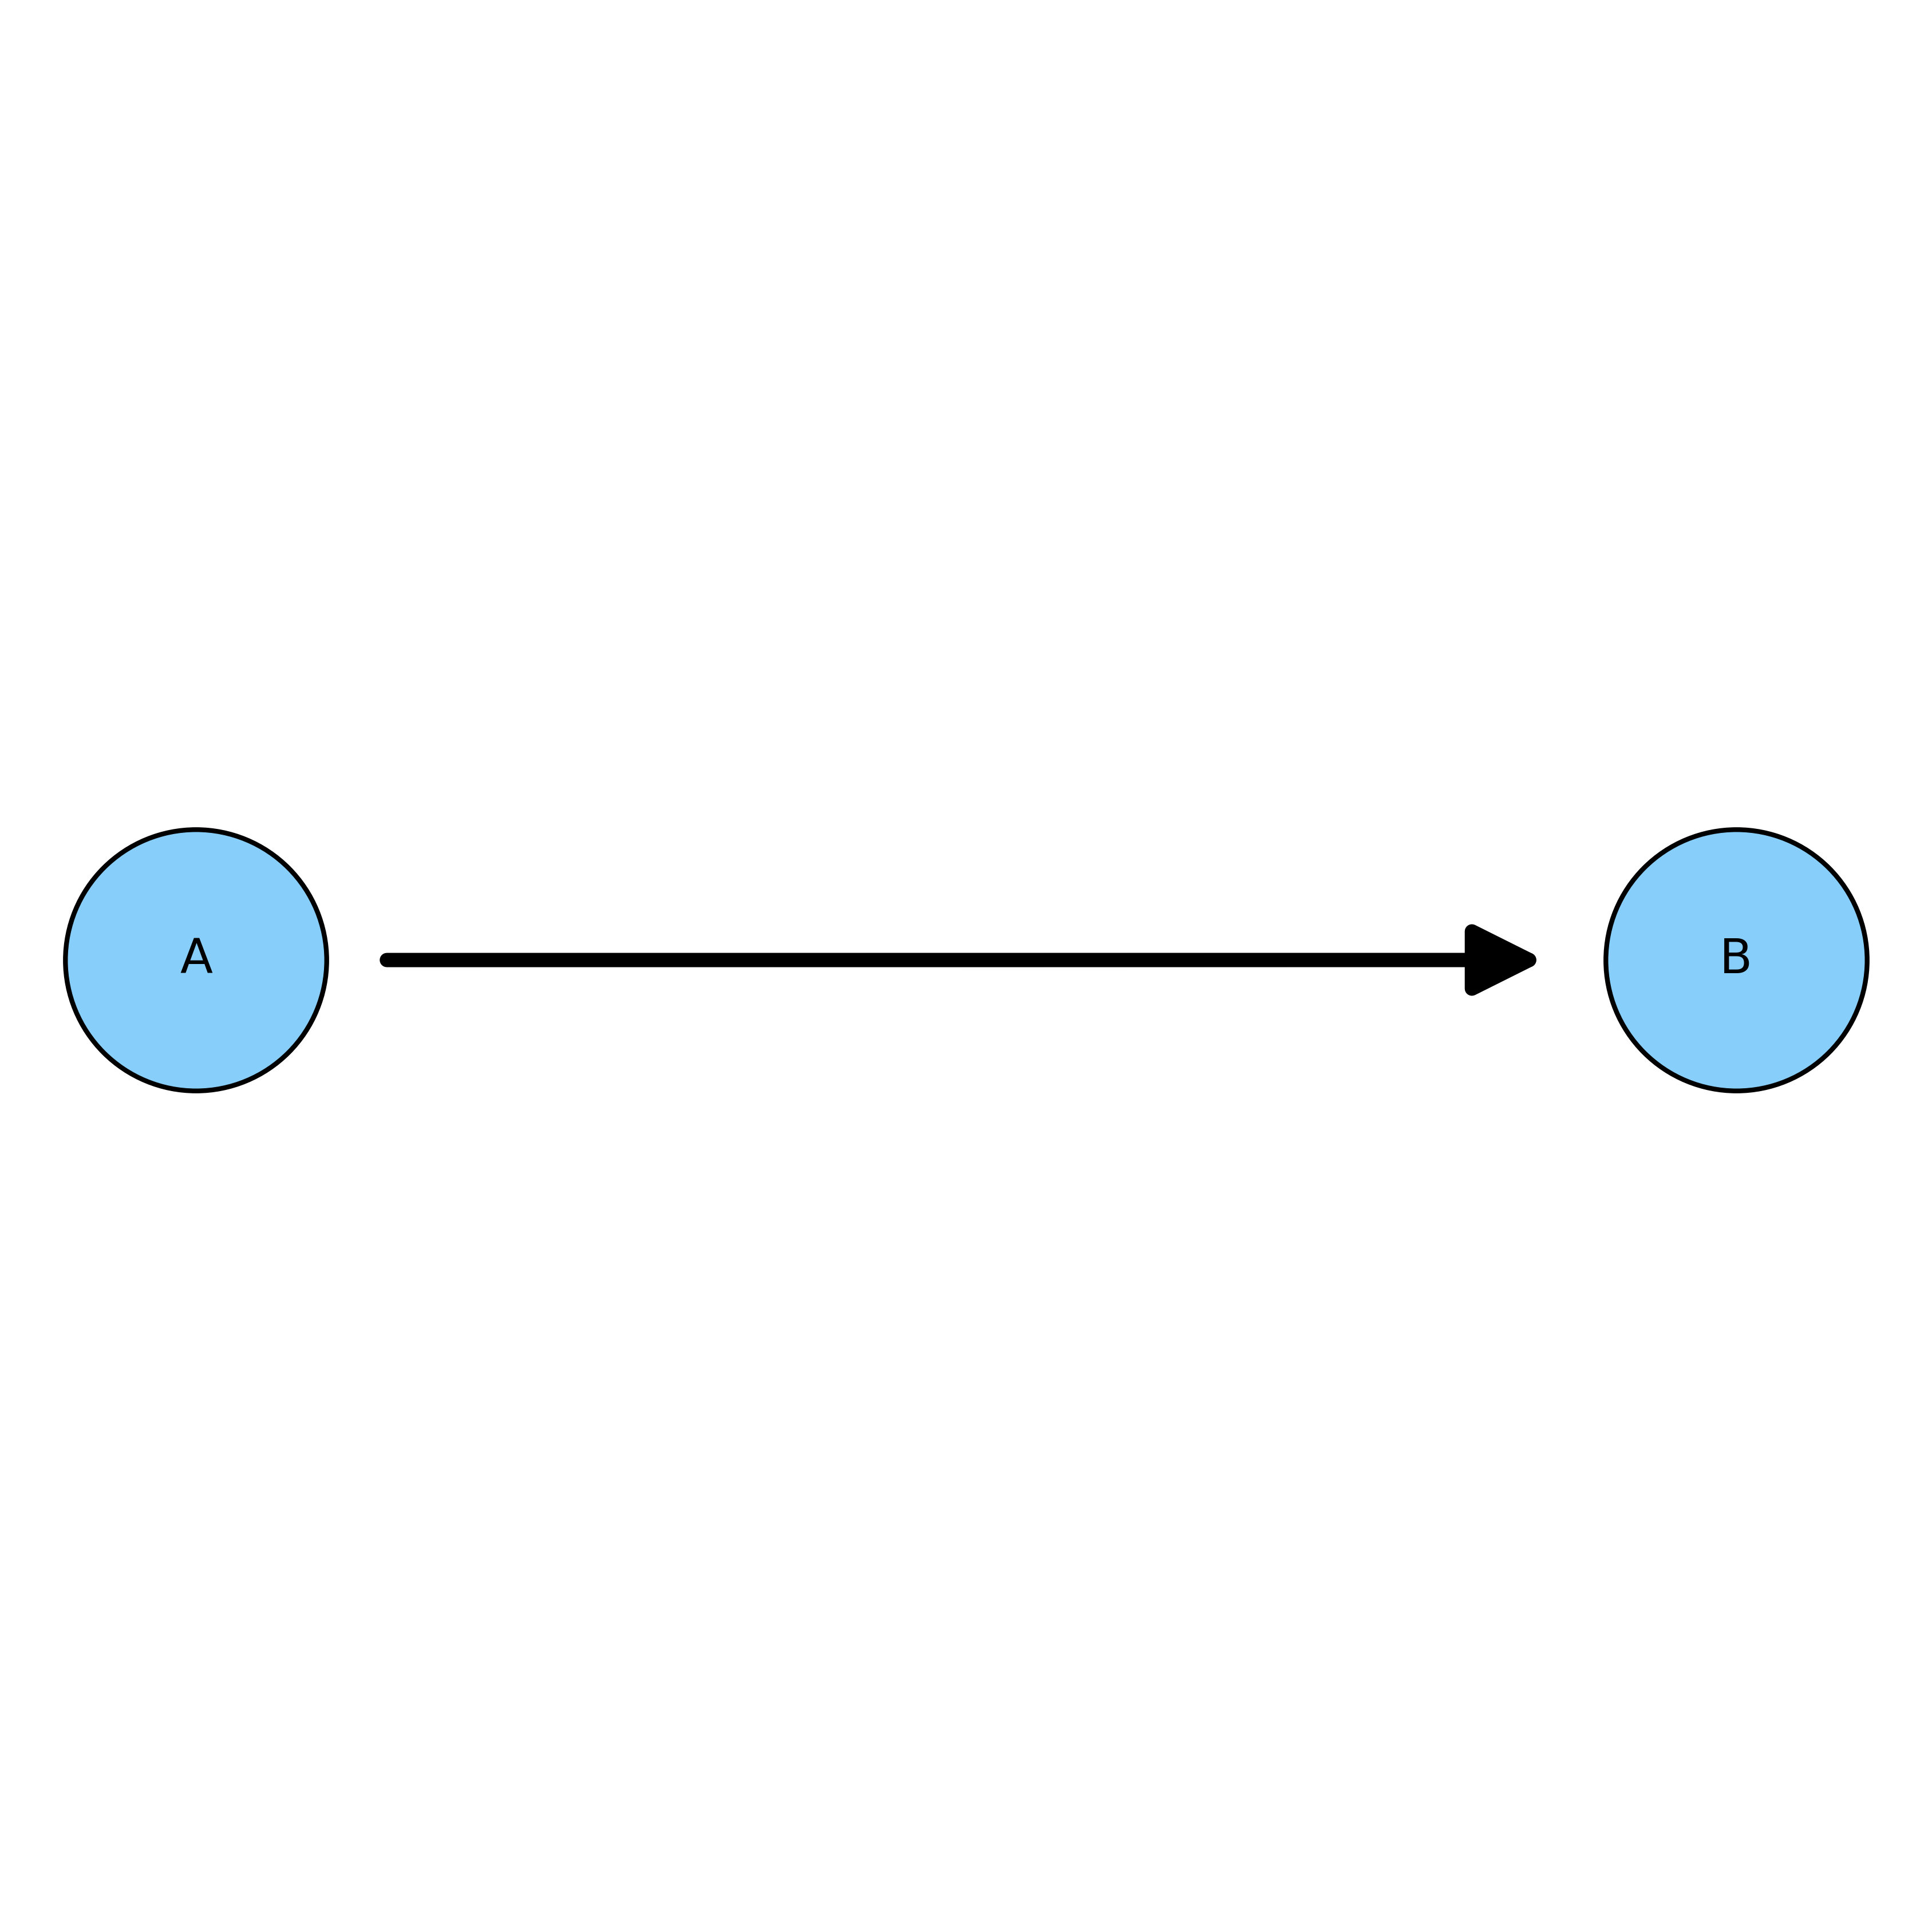

In [21]:
import importlib
from toolbox import GC_functions as GC
importlib.reload(GC)

df_gc_checked=GC.make_stationary(df_gc,['A', 'B'], test_method='ADF',plot=True)

gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=20)
print(gc_results_A_B)
GC.plot_causal_graph(gc_results_A_B, variables=['B', 'A'])

In [4]:
# smooth df_gc with a rolling window of 10
df_gc_smooth = df_gc.rolling(window=10).mean()
df_gc_smooth = df_gc_smooth.dropna()
df_gc_smooth

,A,B
9,-0.154831,-0.035146
10,-0.136197,-0.036481
11,-0.140626,-0.029193
12,-0.127506,-0.003058
13,-0.117945,0.002367
...,...,...
65,0.806643,0.440413
66,0.815483,0.444453
67,0.792848,0.446317
68,0.795738,0.414364


ADF Statistic: -1.3301644941565394
p-value: 0.6152615510797498
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665
The series is not stationary.


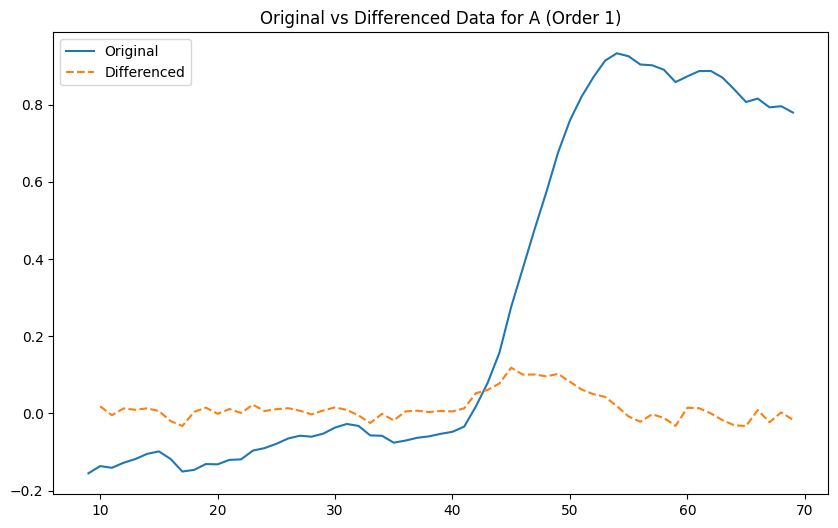

ADF Statistic: -1.9239268369450164
p-value: 0.3208902292626795
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665
The series is not stationary.


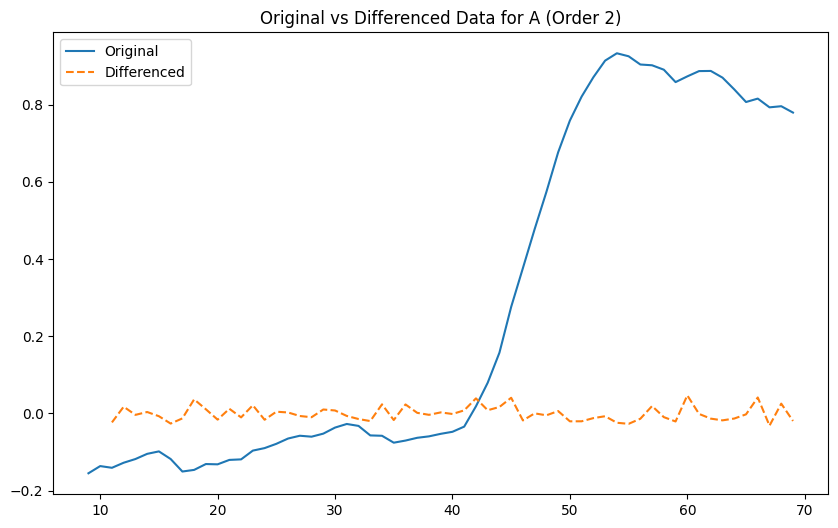

ADF Statistic: -8.729957778382188
p-value: 3.211603149925917e-14
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944
The series is stationary.
Series in column 'A' is stationary after 2 differencing operation(s).
ADF Statistic: -1.1897289391434946
p-value: 0.6779983833892598
Critical Values:
	1%: -3.5714715250448363
	5%: -2.922629480573571
	10%: -2.5993358475635153
The series is not stationary.


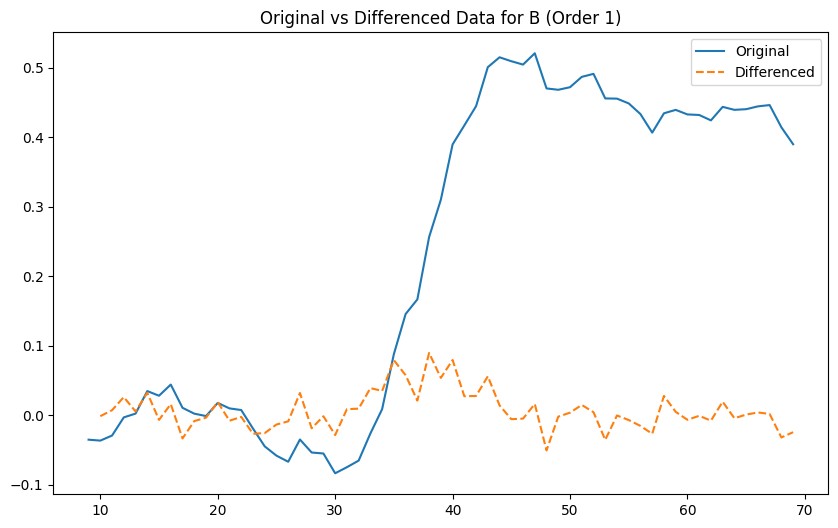

ADF Statistic: -1.8475278831686588
p-value: 0.35713353677252874
Critical Values:
	1%: -3.5714715250448363
	5%: -2.922629480573571
	10%: -2.5993358475635153
The series is not stationary.


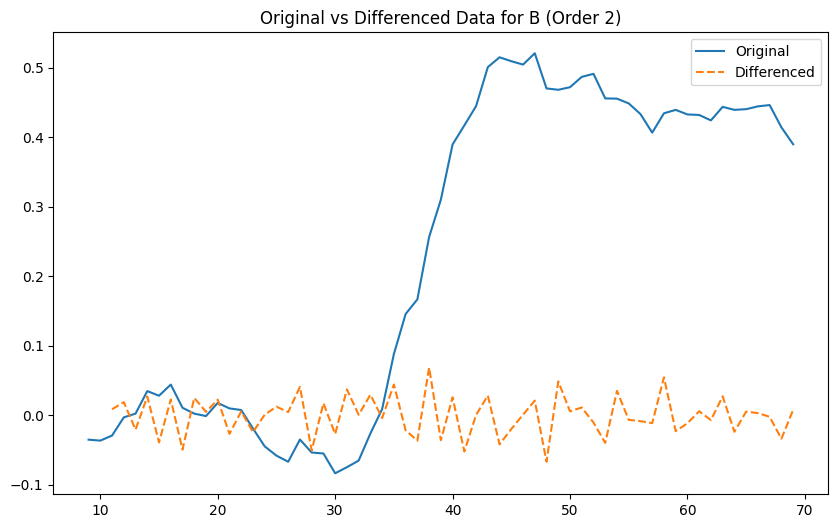

ADF Statistic: -2.972403971752081
p-value: 0.03755312956506651
Critical Values:
	1%: -3.5745892596209488
	5%: -2.9239543084490744
	10%: -2.6000391840277777
The series is stationary.
Series in column 'B' is stationary after 2 differencing operation(s).
Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    6.465               0.009                17                True
B => A    3.059               0.037                3                True

[{'variables': ('A', 'B'), 'XY': True, 'YX': True}]


c:\Users\zps19\.conda\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\zps19\.conda\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


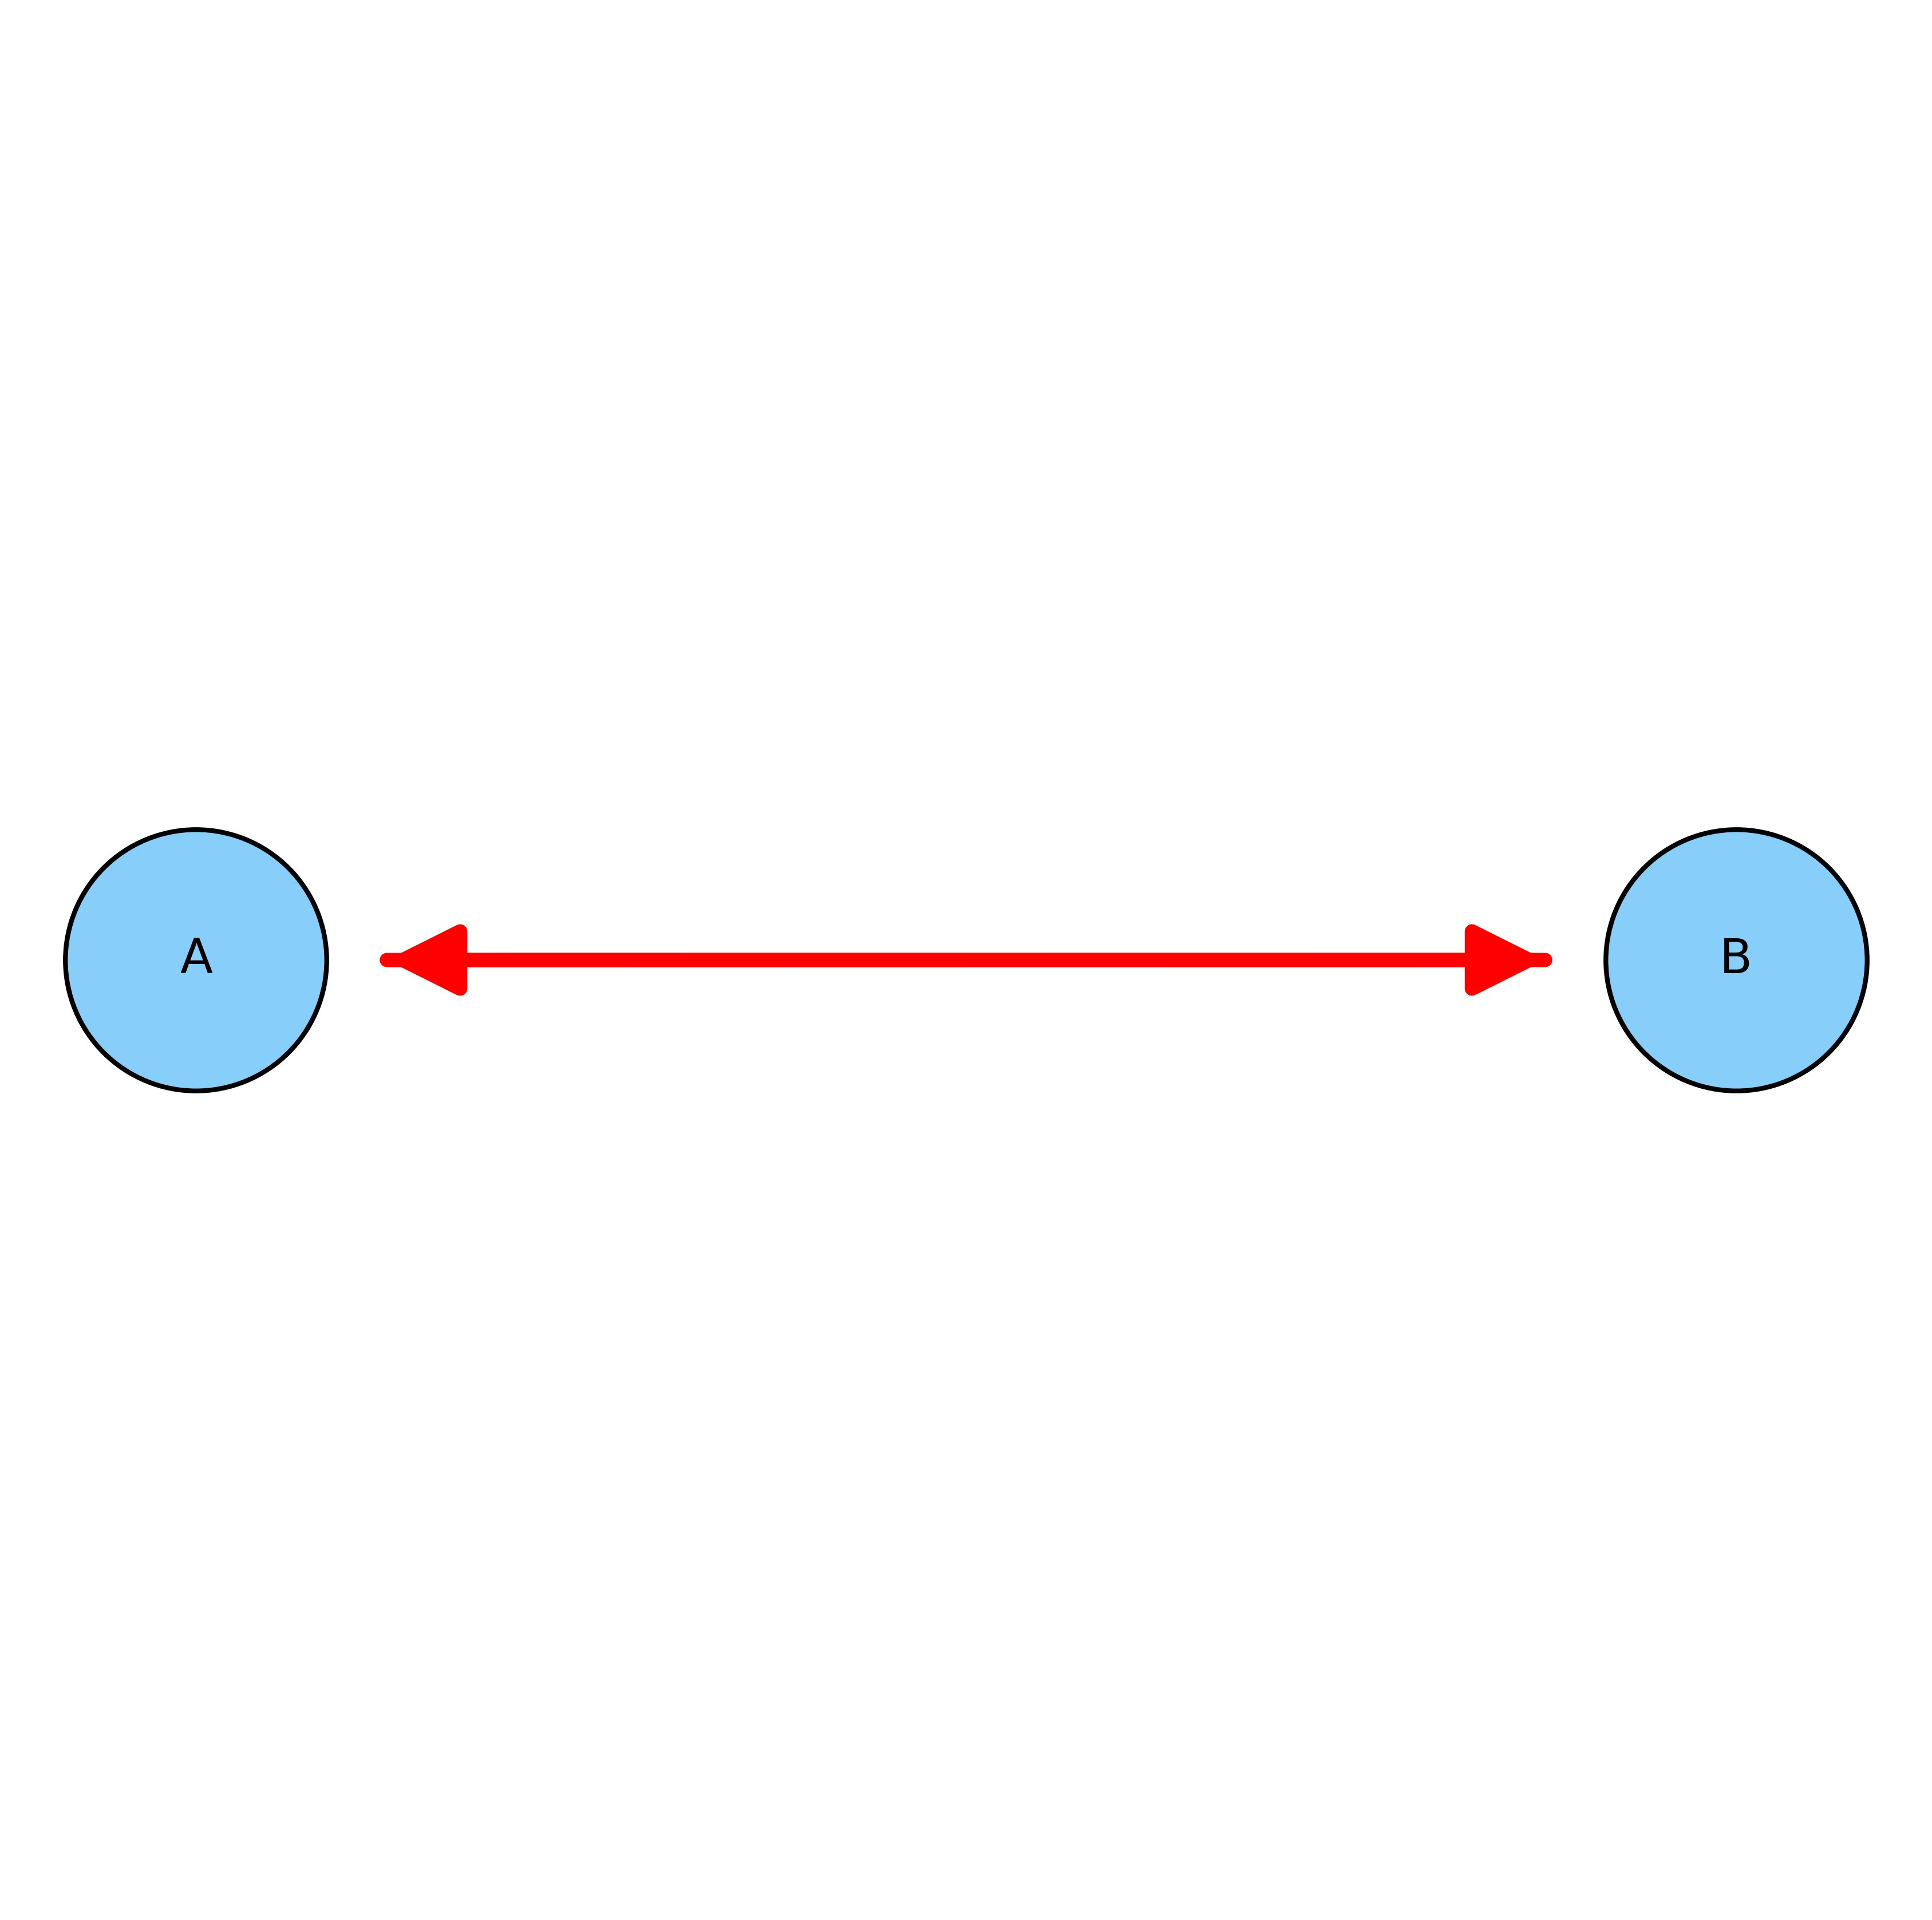

In [6]:
import importlib
from toolbox import GC_functions as GC
importlib.reload(GC)

df_gc_smooth_checked=GC.make_stationary(df_gc_smooth,['A', 'B'], test_method='ADF',plot=True)

gc_results_smoothed_A_B = GC.gc4vars(df_gc_smooth_checked, max_lags=18)
print(gc_results_smoothed_A_B)
GC.plot_causal_graph(gc_results_smoothed_A_B, variables=['B', 'A'])